In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st
from sklearn.metrics.pairwise import pairwise_distances
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.colors as colors

## Input data

Requirements: df with the columns: Patient, Sample, cdr3pep and freq

**TO DO:** add UFI to the table

In [2]:
chain = "IGH"
excel_file = "VASAseq-CDR3-" + chain + ".xlsx"
clones_file = excel_file.replace(".xlsx", "-clones.xlsx")
count_cdr3_barcodes_file = excel_file.replace(".xlsx", "-count-cdr3-barcodes.xlsx")
plotfile = excel_file.replace(".xlsx", ".pdf")
suspects_list = excel_file.replace(".xlsx", ".txt")
mydir = "VASAseq/"
myfiles = [x for x in os.listdir(mydir) if chain in x]
myfiles[:10]

['GCTTCTTC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'ATGAGCAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'CGTAGAAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GCGTATAG_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'ACGAACAC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'TTCAGCGT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GACAAACC_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GCCATCTT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'CCTCTCAA_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv',
 'GGACCTTT_S1.assembled.fastq.gz-IGH_HUMAN-CDR3.csv']

In [3]:
# Read well positions and barcodes
df_wells = pd.read_excel("/home/barbera/Downloads/VASAseq/celseq2_primers.xlsx")
df_wells = df_wells.rename(columns={'Well Position': 'Patient', 'Cell Barcode': 'Sample'})
cols = ['Patient', 'Sample']
df_wells = df_wells[cols]
df_wells.head()

,Patient,Sample
0,A1,CGTCTAAT
1,A2,AGACTCGT
2,A3,GCACGTCA
3,A4,TCAACGAC
4,A5,ATTTAGCG


In [4]:
ufi_files = [x for x in os.listdir("VASAseq-UFIs") if x.endswith("-ufis.csv")]
df_ufis = pd.read_csv("VASAseq-UFIs/" + ufi_files[0], header=None, sep="\t")

for f in ufi_files[1:]:
    f = "VASAseq-UFIs/" + f
    df_ufis = pd.concat([df_ufis, pd.read_csv(f, header=None, sep="\t")])
df_ufis = df_ufis.rename(columns={0: "acc", 1: "ufi"})
df_ufis.tail()

,acc,ufi
1472,ST-E00127:1241:HHKC7CCX2:5:2224:23652:52871,CTTGAA
1473,ST-E00127:1241:HHKC7CCX2:5:2224:19025:56106,GGTGGC
1474,ST-E00127:1241:HHKC7CCX2:5:2224:5954:66478,TTTAGG
1475,ST-E00127:1241:HHKC7CCX2:5:2224:23368:68447,TCACAG
1476,ST-E00127:1241:HHKC7CCX2:5:2224:8055:72965,TGATGA


In [5]:
def readCdr3File(f, df_ufis):
    barcode = f.split("/")[-1].split("_")[0]
    df_cdr3 = pd.read_csv(f, sep="\t", header=None)
    df_cdr3 = df_cdr3.rename(columns={0: "acc", 4: "cdr3pep"})
    df_cdr3 = df_cdr3.merge(df_ufis, on="acc")
    df = df_cdr3.groupby("cdr3pep").agg({'acc': 'nunique', 'ufi': 'nunique'})
    df = df.reset_index()
    df["Sample"] = barcode
    return(df)

f = mydir + myfiles[0]
df = readCdr3File(f, df_ufis)
df.head()

,cdr3pep,acc,ufi,Sample
0,CARDSGHSYALDVW,12,1,GCTTCTTC


In [6]:
for f in myfiles[1:]:
    f = mydir + f
    df = pd.concat([df, readCdr3File(f, df_ufis)], ignore_index=True)
df = df.rename(columns={'acc': 'freq'})
df.tail()

,cdr3pep,freq,ufi,Sample
3300,CARLGYDSSGYYYGELYFDYW,1,1,CGGTAATC
3301,CARDPEWLGYYYYCMDVW,1,1,ATCGACGA
3302,CARHSWYTSGWPSDYW,1,1,ATCGACGA
3303,CARHSWYTSGWPSDYW,1,1,GTTCTTGC
3304,CATRGYCSGASCYKVYYYGMDVW,4,1,GGGGATTT


In [7]:
df = df.merge(df_wells, how="left", on="Sample")
df.head()

,cdr3pep,freq,ufi,Sample,Patient
0,CARDSGHSYALDVW,12,1,GCTTCTTC,I21
1,CADIRAYDSPLW,1,1,ATGAGCAG,E5
2,CADIWADDSPLW,1,1,ATGAGCAG,E5
3,CADIWAYDSPLR,1,1,ATGAGCAG,E5
4,CADIWAYDSPLW,49,2,ATGAGCAG,E5


In [8]:
df.to_excel(clones_file)
print("Wrote", clones_file, "to disk")

Wrote VASAseq-CDR3-IGH-clones.xlsx to disk


In [9]:
# Export table with CDR3s and number of barcodes they occur in
concatValues = lambda x: ",".join(x)
df_grouped = df.groupby("cdr3pep").agg({'Patient': [concatValues, 'nunique']})
df_grouped = df_grouped.reset_index()
df_grouped = df_grouped.sort_values(by = ('Patient', 'nunique'), ascending=False)
df_grouped.head()

cdr3pep                                            Patient  \
                                                                   <lambda>   
1992     CASFLGGQWLQFDYW  F9,A21,L5,J6,O4,I23,H13,H15,F16,K8,I2,L13,A6,F...   
891     CARHSWYTSGWPSDYW  F9,P8,A21,N3,I14,K13,C10,D21,F16,K8,B16,I12,F7...   
1797     CARVKEYDFGGMDVW  D20,N11,A15,D21,M5,K8,I12,N5,K12,F23,A13,F17,P...   
318   CARDPEWLGYYYYYMDVW  P8,I23,D21,N5,F23,H21,P4,N4,A16,A11,K15,M9,K1,...   
556      CARGGYNRRREFDYW  J8,O7,D12,F3,I5,K12,P7,E8,C6,A11,D19,K6,E3,O5,...   

              
     nunique  
1992      57  
891       43  
1797      38  
318       24  
556       23

In [10]:
df_grouped.to_excel(count_cdr3_barcodes_file)
print("Wrote", count_cdr3_barcodes_file, "to disk")

Wrote VASAseq-CDR3-IGH-count-cdr3-barcodes.xlsx to disk


## Determine distance between samples

In [11]:
df_pivot = df.pivot_table(columns=['Patient','Sample'], index='cdr3pep', values='freq')
df_pivot = df_pivot.fillna(0)
df_pivot.head()

Patient,A11,A12,A13,A15,A16,A18,A2,A21,A5,A6,...,P15,P17,P19,P2,P3,P4,P5,P7,P8,P9
Sample,TACTGGTA,ACGATAGG,GATGTCGA,CACAGCAT,CTTTGACA,GAGTCCTG,AGACTCGT,GGACCTTT,ATTTAGCG,ATACAGAC,...,AACTCTGG,CGTCGTTT,CAGAGAAG,ATCGACGA,CTCATGTC,CCCTAGTA,CCTTTGAC,GCGATATC,ACGAACAC,TTGATGGC
cdr3pep,,,,,,,,,,,,,,,,,,,,,
AAGFVGGQWPQFDHW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AARHPWYTSGGPPDYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
AASFSWGQWLQFDYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
C,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
CAADGSTATTGFLGYW,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [12]:
sim = 1 - pairwise_distances(df_pivot.T, metric = "braycurtis")
sim = pd.DataFrame(sim, index=df_pivot.columns, columns=df_pivot.columns)
sim.head()

,Patient,A11,A12,A13,A15,A16,A18,A2,A21,A5,A6,...,P15,P17,P19,P2,P3,P4,P5,P7,P8,P9
,Sample,TACTGGTA,ACGATAGG,GATGTCGA,CACAGCAT,CTTTGACA,GAGTCCTG,AGACTCGT,GGACCTTT,ATTTAGCG,ATACAGAC,...,AACTCTGG,CGTCGTTT,CAGAGAAG,ATCGACGA,CTCATGTC,CCCTAGTA,CCTTTGAC,GCGATATC,ACGAACAC,TTGATGGC
Patient,Sample,,,,,,,,,,,,,,,,,,,,,
A11,TACTGGTA,1.000000,0.0,0.000000,0.000000,0.007407,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.009804,0.000000,0.009901,0.009804,0.000000
A12,ACGATAGG,0.000000,1.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
A13,GATGTCGA,0.000000,0.0,1.000000,0.153846,0.000000,0.111111,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.181818,0.133333,0.000000,0.153846,0.000000,0.181818
A15,CACAGCAT,0.000000,0.0,0.153846,1.000000,0.000000,0.363636,0.0,0.000000,0.0,0.000000,...,0.000000,0.0,0.0,0.0,0.500000,0.250000,0.000000,0.666667,0.000000,0.500000
A16,CTTTGACA,0.007407,0.0,0.000000,0.000000,1.000000,0.000000,0.0,0.024691,0.0,0.027027,...,0.027397,0.0,0.0,0.0,0.000000,0.052632,0.027778,0.000000,0.026316,0.000000


In [13]:
sim.to_excel(excel_file)
print("Wrote", excel_file, "to disk")

Wrote VASAseq-CDR3-IGH.xlsx to disk


## Create a heatmap

In [14]:
def drawBox(end, length):
    '''
    Description: draw a square with lines
    In: start (int), length (int)
    Out: None, 4 lines will be drawn on the canvas
    '''
    linewidth = 5
    low = end - length
    high = end
    plt.plot([low, high], [high, high], 'k-', lw=linewidth)   # N
    plt.plot([high, high], [low, high], 'k-', lw=linewidth)   # E
    plt.plot([low, high], [low, low], 'k-', lw=linewidth)     # S
    plt.plot([low, low], [low, high], 'k-', lw=linewidth)     # W

In [15]:
def drawHeatmap(overlap):
    font = {'family' : 'sans-serif',
            'weight' : 'normal',
            'size'   : 22}

    matplotlib.rc('font', **font)

    fig, ax = plt.subplots(figsize=(60, 60))
    fig.subplots_adjust(bottom=0.3)

    # is used for log scaling
    Z1 = overlap.values
    Z1[Z1 <= 0] = Z1[Z1 > 0].min()  # Replace any value below or equal to zero with lowest value above zero
    
    print("min value:", Z1.min())
    print("max value:", Z1.max())

    # get the patient-id
    labels_x = [x[0] for x in overlap.index]
    labels_y = [y[0] for y in overlap.columns]

    # draw heatmap
    plt.pcolor(overlap.values, cmap=plt.cm.viridis, norm=colors.LogNorm(vmin=Z1.min(), vmax=Z1.max()))
    #plt.pcolor(overlap.values, cmap=plt.cm.viridis)
    plt.colorbar()
    plt.yticks(np.arange(0.5, len(overlap.index), 1), overlap.columns, rotation=0)
    plt.xticks(np.arange(0.5, len(overlap.columns), 1), overlap.index, rotation=90)

    # Add lines around same patient-id
    prev_label = None
    length = 0
    for i in range(len(labels_x)):
        if prev_label is not None and prev_label != labels_x[i]:
            drawBox(i, length)
            length = 0
        prev_label = labels_x[i]
        length +=1
    i += 1
    drawBox(i, length)

    # Save figure to file
    fig.savefig(plotfile)
    print("Wrote", plotfile, "to disk")

min value: 0.0001591596371159909
max value: 1.0
Wrote VASAseq-CDR3-IGH.pdf to disk


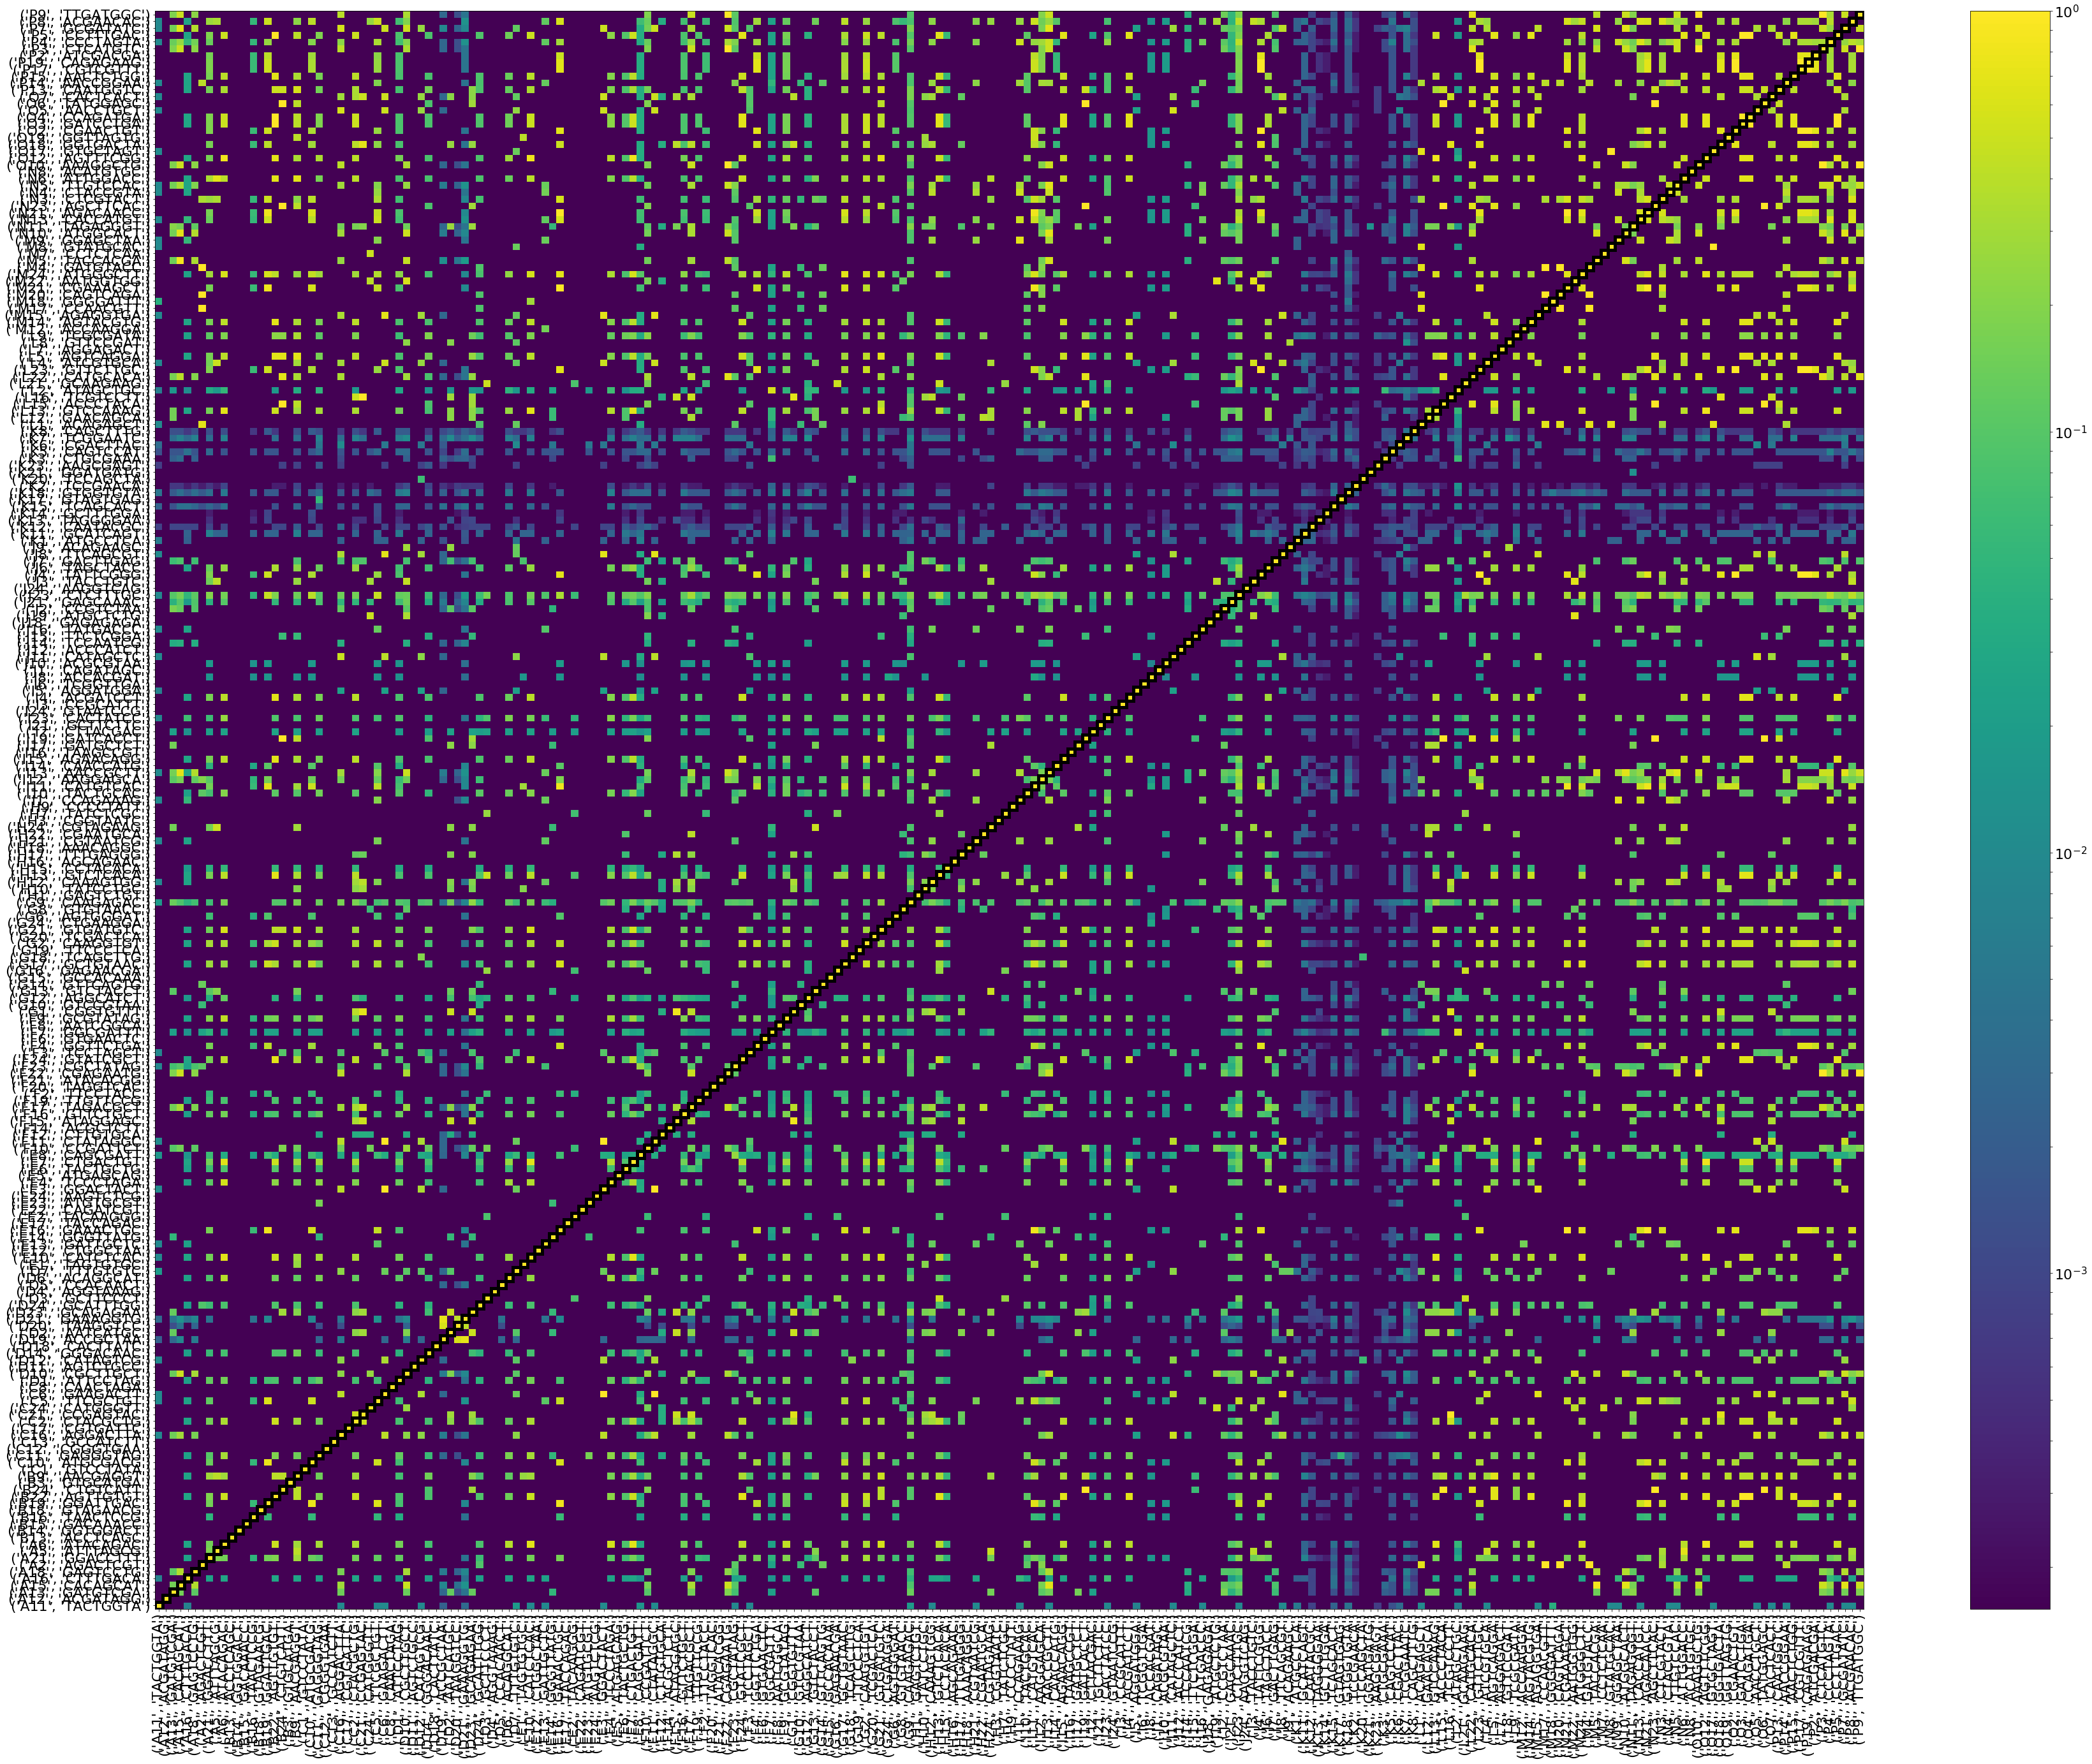

In [16]:
drawHeatmap(sim)

## Highlight anomalies

In [17]:
# get index pairs of same patient (divide same vs not same sample) and list indices for different patients
same_sample = list()
same_patient = list()
diff_patient = list()
for x in sim.index:
    for y in sim.columns:
        if x[0] == y[0]:  # same patient
            if x[1] == y[1]:  # same sample
                same_sample.append((x, y))
            else:        # same patient, but not same sample
                same_patient.append((x, y))
        else:             # not same patient
            diff_patient.append((x,y))                    

In [18]:
# Get values of same patient (but different samples) and values for different patients
values_same_patient = [sim.loc[x][y] for x,y in same_patient]
values_diff_patient = [sim.loc[x][y] for x,y in diff_patient]
mean_diff_patient = np.mean(values_diff_patient)
std_diff_patient = np.std(values_diff_patient)
threshold = mean_diff_patient + 4 * std_diff_patient
print("mean same patient", np.mean(values_same_patient), np.std(values_same_patient))
print("mean diff patient", mean_diff_patient, std_diff_patient)
print("threshold", threshold)

mean same patient nan nan
mean diff patient 0.023712268218771895 0.0951045483494903
threshold 0.40413046161673305


/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:135: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:105: RuntimeWarning: invalid value encountered in true_divide
  arrmean, rcount, out=arrmean, casting='unsafe', subok=False)
/home/barbera/anaconda3/lib/python3.6/site-packages/numpy/core/_methods.py:127: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


{'boxes': [<matplotlib.lines.Line2D at 0x7f507a852f98>,
 'caps': [<matplotlib.lines.Line2D at 0x7f507a85c9e8>,
 'fliers': [<matplotlib.lines.Line2D at 0x7f507a8656a0>,
 'means': [],
 'medians': [<matplotlib.lines.Line2D at 0x7f507a865278>,
 'whiskers': [<matplotlib.lines.Line2D at 0x7f507a85c128>,
  <matplotlib.lines.Line2D at 0x7f507a86d3c8>]}

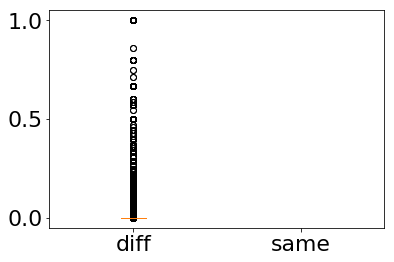

In [19]:
# Boxplot
plt.boxplot([values_diff_patient, values_same_patient], labels=['diff', 'same'])

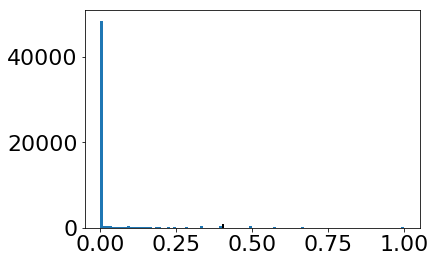

In [20]:
# Histogram
plt.hist(values_diff_patient, bins=100)
plt.hist(values_same_patient, bins=100)
plt.plot([threshold, threshold], [0, 750], 'k-', lw=2)

In [21]:
# Print sample names if similarity is twice the 95% interval
fhOut = open(suspects_list, "w")
check_samples = list()
for i,j in diff_patient:
    if sim.loc[i][j] > threshold:
        print(i, j, sim.loc[i][j])
        print(i, j, sim.loc[i][j], file=fhOut)
        check_samples.append((i,j))
fhOut.close()
print("Wrote", suspects_list, "to disk")

('A15', 'CACAGCAT') ('D10', 'CGCTTGCT') 0.5
('A15', 'CACAGCAT') ('F22', 'CGAGAATG') 0.5
('A15', 'CACAGCAT') ('I13', 'AACCGCTT') 0.6666666666666667
('A15', 'CACAGCAT') ('M5', 'TACCACGA') 0.8571428571428572
('A15', 'CACAGCAT') ('N10', 'ATGGCACT') 0.6666666666666667
('A15', 'CACAGCAT') ('O10', 'AAAGGCTG') 0.5
('A15', 'CACAGCAT') ('P3', 'CTCATGTC') 0.5
('A15', 'CACAGCAT') ('P7', 'GCGATATC') 0.6666666666666667
('A15', 'CACAGCAT') ('P9', 'TTGATGGC') 0.5
('A2', 'AGACTCGT') ('L1', 'ACAGAGCT') 0.6666666666666667
('A2', 'AGACTCGT') ('M17', 'CCAACGTT') 1.0
('A2', 'AGACTCGT') ('M20', 'CAGTCAGA') 1.0
('A2', 'AGACTCGT') ('M4', 'GATGTACC') 1.0
('A5', 'ATTTAGCG') ('H24', 'CGTAGAAG') 0.5
('A5', 'ATTTAGCG') ('L4', 'ATCGTGCA') 0.5
('A5', 'ATTTAGCG') ('N6', 'ATTGGACC') 0.6666666666666667
('A6', 'ATACAGAC') ('B22', 'AGTTGTGT') 0.5
('A6', 'ATACAGAC') ('E10', 'CATCTCAC') 0.6666666666666667
('A6', 'ATACAGAC') ('E4', 'TCCCTAGA') 0.5454545454545454
('A6', 'ATACAGAC') ('E7', 'CTGACTGT') 0.6666666666666667
('A6',

('E3', 'GGACTACT') ('C6', 'GAAGACTT') 1.0
('E3', 'GGACTACT') ('F11', 'CTATAGGC') 1.0
('E3', 'GGACTACT') ('J8', 'TTCAGCGT') 0.6666666666666667
('E3', 'GGACTACT') ('L4', 'ATCGTGCA') 0.5
('E3', 'GGACTACT') ('M15', 'AGAGGTGA') 0.6666666666666667
('E3', 'GGACTACT') ('O5', 'AACCTGCT') 0.5
('E3', 'GGACTACT') ('O7', 'CACTCACT') 0.5
('E3', 'GGACTACT') ('P7', 'GCGATATC') 0.5
('E4', 'TCCCTAGA') ('A6', 'ATACAGAC') 0.5454545454545454
('E7', 'CTGACTGT') ('A6', 'ATACAGAC') 0.6666666666666667
('E7', 'CTGACTGT') ('B22', 'AGTTGTGT') 0.5
('E7', 'CTGACTGT') ('E10', 'CATCTCAC') 0.6666666666666667
('E7', 'CTGACTGT') ('G21', 'GTGATGTC') 0.5714285714285714
('E7', 'CTGACTGT') ('L13', 'GTCCAAAG') 0.6666666666666667
('E7', 'CTGACTGT') ('M24', 'ATGGGCTT') 0.5714285714285714
('E7', 'CTGACTGT') ('O12', 'AGTTTCGG') 0.8
('E7', 'CTGACTGT') ('O3', 'GATCCTGA') 0.5
('E7', 'CTGACTGT') ('O4', 'CCAGATGA') 0.5
('E7', 'CTGACTGT') ('P5', 'CCTTTGAC') 0.5
('F11', 'CTATAGGC') ('C6', 'GAAGACTT') 1.0
('F11', 'CTATAGGC') ('E3', 'GGA

('I4', 'ACGATCCT') ('B22', 'AGTTGTGT') 0.6666666666666667
('I4', 'ACGATCCT') ('F24', 'GTATCGCT') 0.5
('I4', 'ACGATCCT') ('H13', 'GTCTCACA') 0.5
('I4', 'ACGATCCT') ('I15', 'AGAACAGG') 0.5
('I4', 'ACGATCCT') ('L5', 'AGTCAGGA') 0.5
('I4', 'ACGATCCT') ('M14', 'AGTACGTG') 0.5
('I4', 'ACGATCCT') ('N6', 'ATTGGACC') 0.5
('I4', 'ACGATCCT') ('O12', 'AGTTTCGG') 0.5
('I4', 'ACGATCCT') ('O3', 'GATCCTGA') 0.6666666666666667
('I4', 'ACGATCCT') ('O4', 'CCAGATGA') 0.6666666666666667
('I4', 'ACGATCCT') ('P15', 'AACTCTGG') 0.5
('I4', 'ACGATCCT') ('P5', 'CCTTTGAC') 0.6666666666666667
('J11', 'CATAGCTC') ('C16', 'AGGACTTA') 0.5
('J11', 'CATAGCTC') ('O5', 'AACCTGCT') 0.5714285714285714
('J19', 'ATGCTCTG') ('C24', 'CATGGGTT') 0.5
('J19', 'ATGCTCTG') ('M22', 'AATGGTGG') 0.6666666666666667
('J23', 'CTCTTTGC') ('B19', 'GGATTGAC') 0.46153846153846156
('J23', 'CTCTTTGC') ('C5', 'TTCGCTGT') 0.47058823529411764
('J23', 'CTCTTTGC') ('M24', 'ATGGGCTT') 0.4285714285714286
('J3', 'TACCTGTC') ('D10', 'CGCTTGCT') 0.44444

('M5', 'TACCACGA') ('A15', 'CACAGCAT') 0.8571428571428572
('M5', 'TACCACGA') ('D10', 'CGCTTGCT') 0.4444444444444444
('M5', 'TACCACGA') ('I13', 'AACCGCTT') 0.5714285714285714
('M5', 'TACCACGA') ('N10', 'ATGGCACT') 0.5714285714285714
('M5', 'TACCACGA') ('P7', 'GCGATATC') 0.5714285714285714
('M7', 'CCTCTCAA') ('C24', 'CATGGGTT') 0.5
('M8', 'GTATGCAC') ('L1', 'ACAGAGCT') 0.6666666666666667
('M8', 'GTATGCAC') ('O17', 'GTGCTAGT') 1.0
('M9', 'GGAGCTAA') ('I1', 'CCAGAAAG') 0.6666666666666667
('M9', 'GGAGCTAA') ('N13', 'CACCATGT') 0.5
('M9', 'GGAGCTAA') ('N4', 'CTACCGTA') 0.5
('M9', 'GGAGCTAA') ('P4', 'CCCTAGTA') 0.5
('N10', 'ATGGCACT') ('A15', 'CACAGCAT') 0.6666666666666667
('N10', 'ATGGCACT') ('D10', 'CGCTTGCT') 0.5
('N10', 'ATGGCACT') ('F22', 'CGAGAATG') 0.5
('N10', 'ATGGCACT') ('I13', 'AACCGCTT') 0.6666666666666667
('N10', 'ATGGCACT') ('M5', 'TACCACGA') 0.5714285714285714
('N10', 'ATGGCACT') ('O10', 'AAAGGCTG') 0.5
('N10', 'ATGGCACT') ('P3', 'CTCATGTC') 0.5
('N10', 'ATGGCACT') ('P7', 'GCGAT

('O6', 'TATGGAGC') ('B24', 'CTGTCATT') 1.0
('O6', 'TATGGAGC') ('I19', 'GATCACCT') 1.0
('O6', 'TATGGAGC') ('L15', 'ACCCTACA') 1.0
('O6', 'TATGGAGC') ('L22', 'CATGCACA') 0.6666666666666667
('O6', 'TATGGAGC') ('L5', 'AGTCAGGA') 0.6666666666666667
('O6', 'TATGGAGC') ('N23', 'AGCTTCAC') 1.0
('O6', 'TATGGAGC') ('P13', 'CAATGGTC') 0.5
('O7', 'CACTCACT') ('C21', 'CCGAGTAC') 0.5
('O7', 'CACTCACT') ('C6', 'GAAGACTT') 0.5
('O7', 'CACTCACT') ('E3', 'GGACTACT') 0.5
('O7', 'CACTCACT') ('F11', 'CTATAGGC') 0.5
('O7', 'CACTCACT') ('L16', 'TCGTCCTT') 0.5
('P13', 'CAATGGTC') ('B22', 'AGTTGTGT') 0.5
('P13', 'CAATGGTC') ('B24', 'CTGTCATT') 0.5
('P13', 'CAATGGTC') ('B9', 'AACGAGGT') 0.5714285714285714
('P13', 'CAATGGTC') ('G21', 'GTGATGTC') 0.5714285714285714
('P13', 'CAATGGTC') ('I19', 'GATCACCT') 0.5
('P13', 'CAATGGTC') ('L15', 'ACCCTACA') 0.5
('P13', 'CAATGGTC') ('L5', 'AGTCAGGA') 0.8
('P13', 'CAATGGTC') ('N23', 'AGCTTCAC') 0.5
('P13', 'CAATGGTC') ('O3', 'GATCCTGA') 0.5
('P13', 'CAATGGTC') ('O4', 'CCAGAT

In [22]:
sim2 = sim.copy()
for i, j in check_samples:
    sim2.loc[i][j] = 1

min value: 0.0001591596371159909
max value: 1.0
Wrote VASAseq-CDR3-IGH-highlighted.pdf to disk


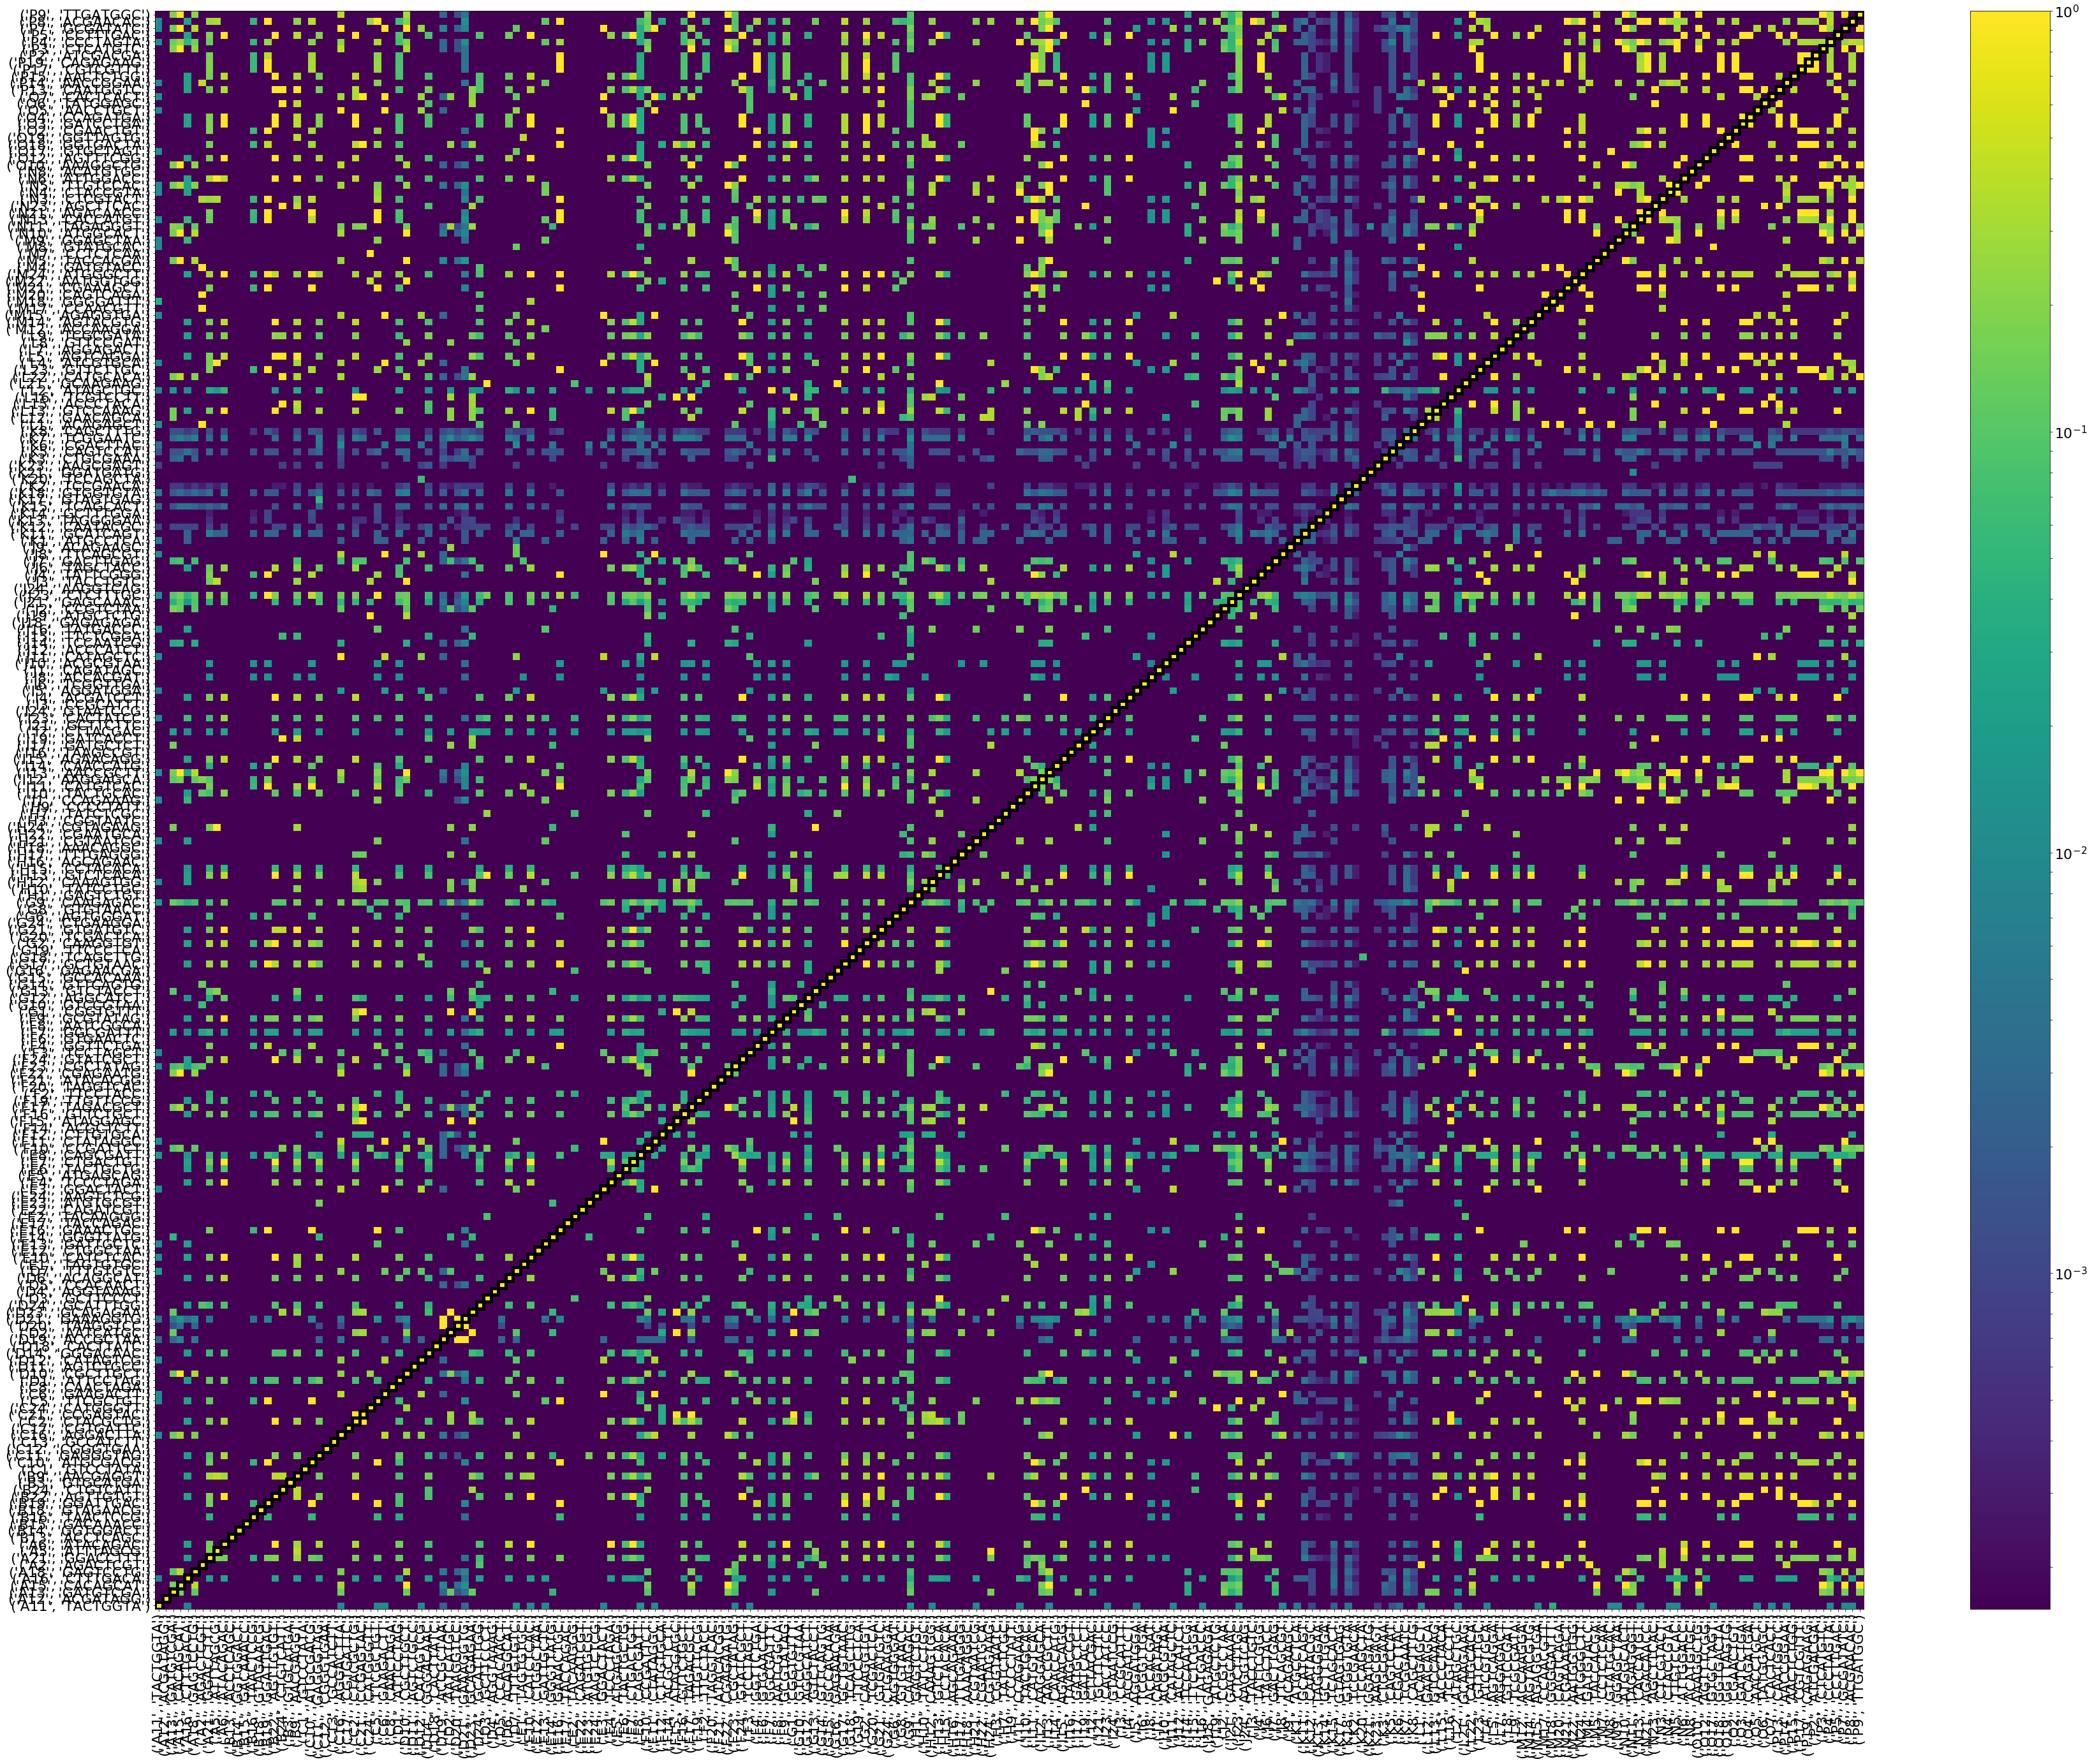

In [23]:
plotfile = plotfile.replace('.pdf', '-highlighted.pdf')
drawHeatmap(sim2)